# **Atlántico**

El Atlántico es uno de los 32 departamentos que conforman la república de Colombia. Se encuentra conformado por 22 Municipios y el Distrito Especial Industrial y Portuario de Barranquilla, su capital.

Está situado al norte del territorio nacional, límita por el norte y noreste con el mar Caribe, en una extensión aproximada de 90 Km; desde el rompeolas occidental en Bocas de Ceniza, hasta las salinas de Galerazamba. Al este, con el río Magdalena, en una longitud de 105 Km, contados desde su desembocadura en Bocas de Ceniza hasta el desprendimiento del Canal del Dique en Calamar; al sur, suroeste y oeste con el departamento de Bolívar desde Calamar hasta las Salinas de Galerazamba.

Presenta un clima tropical de tipo estepa y sabana de carácter árido en la desembocadura del río Magdalena y alrededores de Barranquilla; semi-árido en las fajas aledañas al litoral y al río Magdalena y semihúmedo desde Sabanalarga hacia el sur.

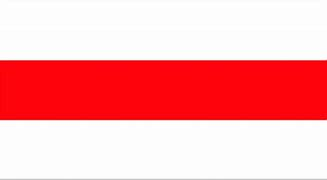

```{note}

Se realizará un análisis excluyendo la ciudad capital Barranquilla.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
from scipy import stats

### Calidad de los datos

In [2]:
# Leer el archivo
df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\procesados\atl_pros.csv", encoding='latin_1', low_memory=False)
# Excluir registros de Barranquilla
df = df[df["municipio"] != "BARRANQUILLA"].copy()
# Guardar solo Barranquilla
#df_barranquilla = df[df["municipio"] == "Barranquilla"].copy()
# Guardar todos los demás (sin Barranquilla)
#df_sin_barranquilla = df[df["municipio"] != "Barranquilla"].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15057 entries, 7 to 31799
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   area                   15057 non-null  object
 1   año                    15057 non-null  int64 
 2   fecha_consulta         15057 non-null  object
 3   fecha_hospitalizacion  9530 non-null   object
 4   fecha_inicio_sintomas  15057 non-null  object
 5   fecha_nacimiento       14534 non-null  object
 6   fecha_notificacion     15057 non-null  object
 7   hospitalizado          15057 non-null  object
 8   muerte                 15057 non-null  object
 9   municipio              15057 non-null  object
 10  regimen_salud          15057 non-null  object
 11  semana                 15057 non-null  int64 
 12  sexo                   15057 non-null  object
 13  tipo_de_caso           15057 non-null  object
 14  evento                 15057 non-null  object
 15  edad_años              1

* Convertir fechas a datetime

In [3]:
# Lista de columnas que quieres convertir
columnas_fecha = ["fecha_consulta", "fecha_inicio_sintomas", "fecha_notificacion", "fecha_nacimiento", "fecha_hospitalizacion"]

for col in columnas_fecha:
    df[col] = pd.to_datetime(df[col], format='mixed')
    print(f"Columna '{col}' convertida a datetime.")

Columna 'fecha_consulta' convertida a datetime.
Columna 'fecha_inicio_sintomas' convertida a datetime.
Columna 'fecha_notificacion' convertida a datetime.
Columna 'fecha_nacimiento' convertida a datetime.
Columna 'fecha_hospitalizacion' convertida a datetime.


* Valores faltantes

In [4]:
# Cantidad de valores nulos por variable
faltantes = df.isnull().sum()
print("\n   Valores faltantes por variable:")
print(faltantes[faltantes > 0])


   Valores faltantes por variable:
fecha_hospitalizacion    5527
fecha_nacimiento          523
dtype: int64


Para el análisis se cuenta con 15,507 registros correspondientes a casos ocurridos en alguno de los 22 municipios del departamento del atlántico, representado en 18 variables explicativas cuya distribución se describe a continuación:

## 2. Descriptivo de variables

In [5]:
def describir_categorica(columna, col_evento="evento"):
    # Conteos y proporciones generales
    tabla = pd.DataFrame({
        "Conteo": columna.value_counts(dropna=False),
        "Proporción": columna.value_counts(normalize=True, dropna=False).round(4)
    })

    # Renombrar índice si hay NaN
    tabla.index = tabla.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Conteos de la variable evento cruzada con la categórica
    crosstab_evento = pd.crosstab(df[columna.name], df[col_evento])

    # Unir todo
    tabla_completa = tabla.join(crosstab_evento)

    # Agregar proporciones específicas para 'Clasico' y 'Grave' si existen
    if "Clasico" in crosstab_evento.columns:
        tabla_completa["Prop_Clasico"] = (tabla_completa["Clasico"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Clasico"] = 0

    if "Grave" in crosstab_evento.columns:
        tabla_completa["Prop_Grave"] = (tabla_completa["Grave"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Grave"] = 0

    print(f"\n📌 Variable: {columna.name}")
    print(tabla_completa)
    print("\n-----------------------------------")



### 2.1 Variables demográficas

- Ciclo vital
- Sexo
- Pertenencia étnica
- Regimen de salud

In [6]:
print("DESCRIPCIÓN DE VARIABLES CATEGÓRICAS")
describir_categorica(df["ciclo_vital"])
describir_categorica(df["sexo"])
describir_categorica(df["grupo_etnico"])
describir_categorica(df["regimen_salud"])


DESCRIPCIÓN DE VARIABLES CATEGÓRICAS

📌 Variable: ciclo_vital
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ciclo_vital                                                                   
Adolescencia        6861      0.4557     6679    182        0.9735      0.0265
Infancia            3368      0.2237     3295     73        0.9783      0.0217
Adulto              3050      0.2026     2957     93        0.9695      0.0305
Primera infancia    1413      0.0938     1389     24        0.9830      0.0170
Adulto mayor         271      0.0180      255     16        0.9410      0.0590
Menor de 1 año        69      0.0046       68      1        0.9855      0.0145
Ancianidad            25      0.0017       23      2        0.9200      0.0800

-----------------------------------

📌 Variable: sexo
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
sexo                                                                   
Masculino    7887      0.523

El análisis de los casos de dengue según variables demográficas evidencia que la mayor carga de enfermedad se concentra en la adolescencia (45,8%), seguida por la población adulta (22,4%) y la infancia (20,6%), en tanto que los demás grupos etarios representan proporciones considerablemente menores. Si bien en todos los ciclos vitales predomina el dengue clásico, se destaca que los adultos mayores (3,9%) y, en mayor medida, la población en ancianidad (8,2%) presentan una proporción más elevada de dengue graves, lo que manifiesta una mayor vulnerabilidad clínica en estas etapas del ciclo vital.

Respecto al sexo, la distribución de los casos es equilibrada, con ligera predominancia en hombres (52,6%), sin diferencias relevantes en la severidad de la enfermedad. En términos étnicos, la casi totalidad de los casos corresponde a la categoría “otro” (98,4%), con una baja representación de poblaciones afrocolombianas, indígenas y Rom. En relación con el régimen de salud, la mayoría de los casos se presentan en el régimen subsidiado (49,0%) y contributivo (44,3%). No obstante, se observa que, a pesar de que los no asegurados representan apenas el 2,2% de la muestra, concentran una mayor proporción de formas graves (5,4%), lo que sugiere una posible asociación entre la ausencia de aseguramiento en salud y un peor desenlace clínico del dengue.

* Edad

menores de 1 año, 68 clasico 1 grave

In [7]:
# Subconjunto de datos para análisis de edad (excluye "Menor de 1 año")
df_edad = df[df["ciclo_vital"] != "Menor de 1 año"].copy()

# Definir orden cronológico SIN "Menor de 1 año"
orden_ciclos_edad = [
    "Primera infancia",
    "Infancia",
    "Adolescencia",
    "Adulto",
    "Adulto mayor",
    "Ancianidad"
]

df_edad["ciclo_vital"] = pd.Categorical(
    df_edad["ciclo_vital"], 
    categories=orden_ciclos_edad, 
    ordered=True
)

In [8]:
def tabla_descriptiva(df, variable, grupo=None):
    """
    Genera una tabla descriptiva (media, mediana, DE, IQR, etc.)
    por grupos (ej. ciclo vital).
    """
    if grupo:
        desc = df.groupby(grupo)[variable].agg(
            n = 'count',
            media = 'mean',
            mediana = 'median',
            sd = 'std',
            q25 = lambda x: np.percentile(x, 25),
            q75 = lambda x: np.percentile(x, 75),
            minimo = 'min',
            maximo = 'max'
        ).reset_index()
    else:
        desc = df[variable].agg(
            n = 'count',
            media = 'mean',
            mediana = 'median',
            sd = 'std',
            q25 = lambda x: np.percentile(x, 25),
            q75 = lambda x: np.percentile(x, 75),
            minimo = 'min',
            maximo = 'max'
        ).to_frame().T
    return desc.round(2)

tabla = tabla_descriptiva(df_edad, variable="edad_años", grupo="ciclo_vital")
tabla

C:\Users\Hp\AppData\Local\Temp\ipykernel_31816\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


,ciclo_vital,n,media,mediana,sd,q25,q75,minimo,maximo
0,Primera infancia,1413,2.66,3.0,1.15,2.0,4.0,1,4
1,Infancia,3368,7.24,7.0,1.38,6.0,8.0,5,9
2,Adolescencia,6861,13.89,14.0,2.67,12.0,16.0,10,19
3,Adulto,3050,29.70,26.0,9.89,22.0,34.0,20,59
4,Adulto mayor,271,68.95,67.0,6.83,63.0,74.5,60,84
5,Ancianidad,25,88.64,88.0,3.38,86.0,90.0,85,97


En términos descriptivos, los valores centrales de la edad concuerdan con los intervalos definidos para cada ciclo:

Primera infancia: mediana de 3 años (RIQ: 2–4), con distribución muy concentrada.

Infancia: mediana de 7 años (RIQ: 6–8), igualmente estrecha.

Adolescencia: mediana de 14 años (RIQ: 12–16), con mayor dispersión (sd = 2,7).

Adulto: mediana de 26 años (RIQ: 22–34), mostrando una mayor heterogeneidad (sd = 9,9), con un rango amplio de 20 a 59 años.

Adulto mayor: mediana de 67 años (RIQ: 63–74,5), con desviación estándar de 6,8 años.

Ancianidad: mediana de 88 años (RIQ: 86–90), con dispersión reducida (sd = 3,4).

Se observa que, mientras en los grupos infantiles y adolescentes la edad presenta distribuciones compactas y esperadas, en la población adulta existe una mayor variabilidad, lo que refleja la amplitud del rango etario en este ciclo. En los adultos mayores y la ancianidad, los valores se concentran en los rangos superiores de la vida, como corresponde a su definición.

En conclusión, la población afectada se concentra principalmente en niños, adolescentes y adultos jóvenes, lo que tiene implicaciones epidemiológicas relevantes para la planificación de estrategias de vigilancia, prevención y control del dengue.

*****

In [9]:
# Tabla para evento Clásico
tabla_clasico = df_edad[df_edad["evento"] == "Clasico"]

print("📌 Evento: Clasico")
tabla_clasico = tabla_descriptiva(tabla_clasico, variable="edad_años", grupo="ciclo_vital")
tabla_clasico

📌 Evento: Clasico


C:\Users\Hp\AppData\Local\Temp\ipykernel_31816\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


,ciclo_vital,n,media,mediana,sd,q25,q75,minimo,maximo
0,Primera infancia,1389,2.65,3.0,1.15,2.0,4.0,1,4
1,Infancia,3295,7.24,7.0,1.38,6.0,8.0,5,9
2,Adolescencia,6679,13.87,14.0,2.66,12.0,16.0,10,19
3,Adulto,2957,29.77,26.0,9.93,22.0,34.0,20,59
4,Adulto mayor,255,69.05,67.0,6.91,63.0,75.0,60,84
5,Ancianidad,23,88.17,87.0,3.04,86.0,89.0,85,97


In [10]:
# Tabla para evento Clásico
tabla_Grave = df_edad[df_edad["evento"] == "Grave"]

print("📌 Evento: Grave")
tabla_Grave = tabla_descriptiva(tabla_Grave, variable="edad_años", grupo="ciclo_vital")
tabla_Grave

📌 Evento: Grave


C:\Users\Hp\AppData\Local\Temp\ipykernel_31816\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


,ciclo_vital,n,media,mediana,sd,q25,q75,minimo,maximo
0,Primera infancia,24,2.79,3.0,1.14,2.00,4.0,1,4
1,Infancia,73,7.47,8.0,1.35,6.00,9.0,5,9
2,Adolescencia,182,14.44,14.0,2.81,12.00,17.0,10,19
3,Adulto,93,27.56,25.0,8.14,21.00,31.0,20,56
4,Adulto mayor,16,67.38,66.5,5.43,62.75,70.0,61,79
5,Ancianidad,2,94.00,94.0,2.83,93.00,95.0,92,96


In [11]:
def prueba_normalidad(df, variable, grupo):
    """
    Aplica prueba de normalidad:
    - Shapiro-Wilk si n < 5000
    - D’Agostino K² si n >= 5000
    """
    resultados = []
    for g, data in df.groupby(grupo):
        valores = data[variable].dropna()
        n = len(valores)
        if n < 5000:
            stat, p = stats.shapiro(valores)
            metodo = "Shapiro-Wilk"
        else:
            stat, p = stats.normaltest(valores)
            metodo = "D’Agostino K²"
        conclusion = "Normal" if p > 0.05 else "No normal"
        resultados.append([g, n, metodo, round(p, 4), conclusion])
    return pd.DataFrame(resultados, columns=[grupo, "n", "Prueba", "p-valor", "Conclusión"])

# --- Prueba de normalidad ---
tabla_norm = prueba_normalidad(df_edad, variable="edad_años", grupo="ciclo_vital")
print("\n Prueba de normalidad:")
print(tabla_norm)



 Prueba de normalidad:
        ciclo_vital     n         Prueba  p-valor Conclusión
0  Primera infancia  1413   Shapiro-Wilk   0.0000  No normal
1          Infancia  3368   Shapiro-Wilk   0.0000  No normal
2      Adolescencia  6861  D’Agostino K²   0.0000  No normal
3            Adulto  3050   Shapiro-Wilk   0.0000  No normal
4      Adulto mayor   271   Shapiro-Wilk   0.0000  No normal
5        Ancianidad    25   Shapiro-Wilk   0.0037  No normal


C:\Users\Hp\AppData\Local\Temp\ipykernel_31816\575974444.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, data in df.groupby(grupo):


La edad no se distribuye normalmente en ningun ciclo vital.

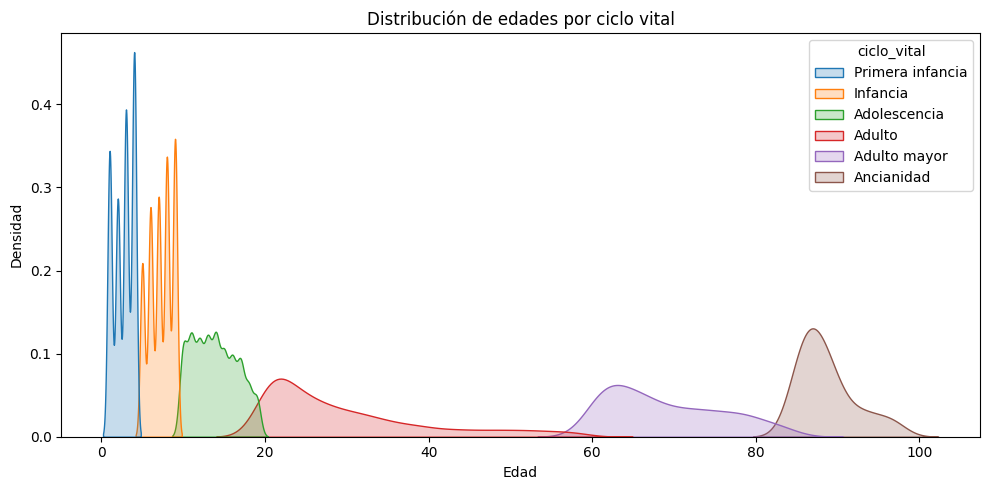

C:\Users\Hp\AppData\Local\Temp\ipykernel_31816\1163753633.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=grupo, y=variable, palette="Set2")


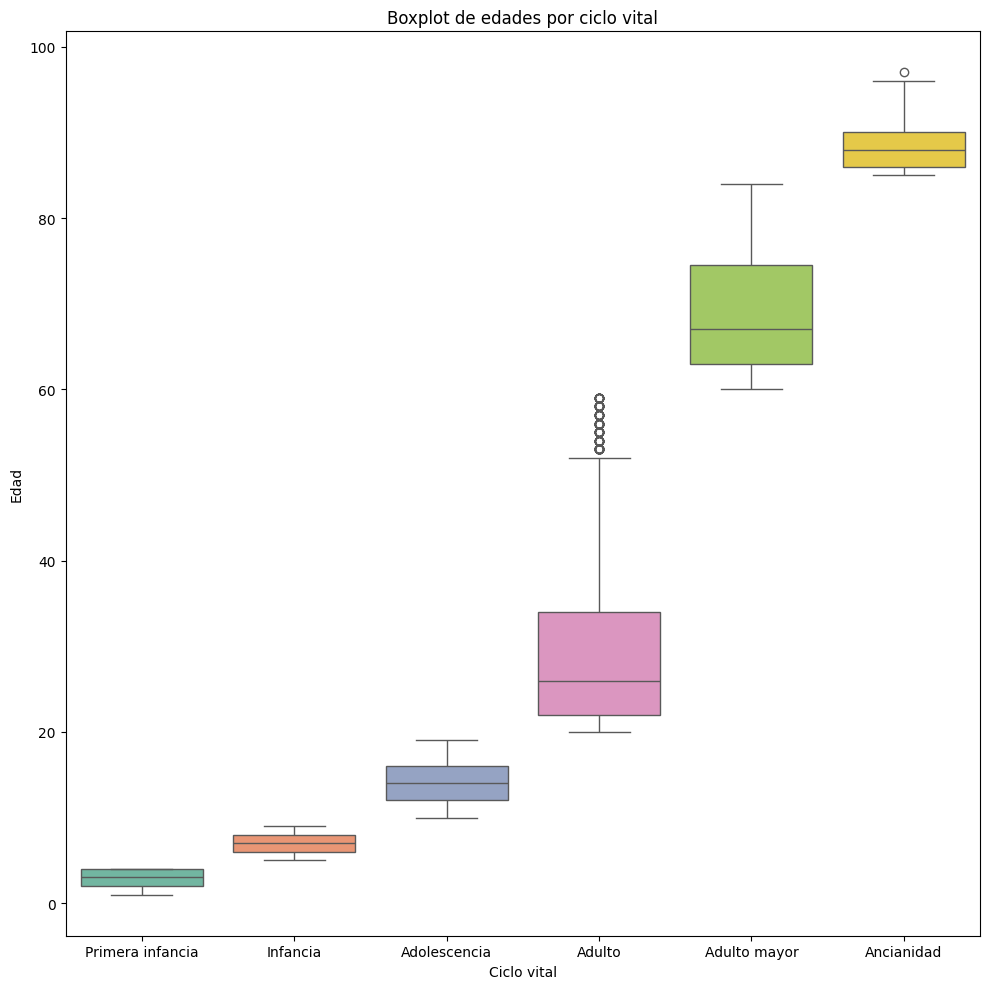

In [12]:
def graficos(df, variable, grupo):
    """
    Genera:
    1. Histograma + densidad global
    2. Densidad por ciclo vital
    3. Boxplot por ciclo vital
    """

    # --- 2. Densidad por ciclo vital ---
    plt.figure(figsize=(10,5))
    sns.kdeplot(data=df, x=variable, hue=grupo, common_norm=False, fill=True)
    plt.title("Distribución de edades por ciclo vital")
    plt.xlabel("Edad")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()

    # --- 3. Boxplot por ciclo vital ---
    plt.figure(figsize=(10,10))
    sns.boxplot(data=df, x=grupo, y=variable, palette="Set2")
    plt.title("Boxplot de edades por ciclo vital")
    plt.xlabel("Ciclo vital")
    plt.ylabel("Edad")
    plt.tight_layout()
    plt.show()

graficos(df_edad, variable="edad_años", grupo="ciclo_vital")

En la primera infancia (1–5 años) y la infancia (6–11 años) se observa una baja dispersión de las edades, lo cual indica una población homogénea y bien delimitada en estos grupos etarios. De igual manera, en la adolescencia (12–18 años) las edades se concentran principalmente en la mitad superior del rango, sin presencia de valores atípicos.

La mayor variabilidad se identifica en la etapa adulta (19–59 años), donde la dispersión es amplia y la mediana se ubica en edades tempranas de la adultez. Se evidencian algunos valores atípicos correspondientes a personas en la franja de los 50 años, lo que sugiere una mayor representación de adultos jóvenes en la población analizada.

En contraste, los grupos de adulto mayor (60–74 años) y ancianidad (≥75 años) muestran una distribución más concentrada, con medianas ubicadas alrededor de los 65 y 88 años, respectivamente. Aunque se identifican valores atípicos en edades cercanas a los 95 años, estos se mantienen dentro de lo esperable para el ciclo vital correspondiente.

En conclusión, los resultados evidencian que la clasificación por ciclos vitales es consistente y refleja adecuadamente la estructura etaria de la población, destacando una concentración de casos en la adultez temprana y una menor dispersión en los extremos del curso de vida.

### 2.2 Variables de evento



In [13]:
describir_categorica(df['evento'])
describir_categorica(df['tipo_de_caso'])
describir_categorica(df['hospitalizado'])
describir_categorica(df['muerte'])


📌 Variable: evento
         Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
evento                                                               
Clasico   14666       0.974    14666      0           1.0         0.0
Grave       391       0.026        0    391           0.0         1.0

-----------------------------------

📌 Variable: tipo_de_caso
                       Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
tipo_de_caso                                                              
Probable                10277      0.6825     9988    289        0.9719   
Conf. por laboratorio    4737      0.3146     4635    102        0.9785   
Conf. por nexo             43      0.0029       43      0        1.0000   

                       Prop_Grave  
tipo_de_caso                       
Probable                   0.0281  
Conf. por laboratorio      0.0215  
Conf. por nexo             0.0000  

-----------------------------------

📌 Variable: hospitalizado
               Co

* Variable: Evento

La distribución de los casos muestra que la gran mayoría corresponden a dengue clásico (97,4%), mientras que una proporción reducida fue clasificada como dengue grave (2,6%). Este hallazgo es consistente con el comportamiento habitual de la enfermedad, donde la forma clásica representa el mayor peso en la carga de morbilidad, mientras que los casos graves constituyen una fracción minoritaria pero de alta relevancia clínica y epidemiológica debido a su potencial de complicaciones y mortalidad.

La mayoría de los registros corresponden a casos probables (68,3%), seguidos por casos confirmados por laboratorio (31,5%) y, en una proporción mínima, por confirmación por nexo epidemiológico (0,3%). Al analizar por tipo de evento, los casos graves se presentan en mayor proporción entre los probables (2,8%) en comparación con los confirmados por laboratorio (2,1%). No se registran casos graves dentro de los confirmados por nexo.

Del total de registros, el 63,3% de los pacientes requirieron hospitalización, mientras que el 36,7% fueron manejados de manera ambulatoria. Al discriminar por evento, la hospitalización se concentra principalmente en casos de dengue grave (40%), aunque también un número considerable de casos clásicos (96%) fueron hospitalizados. 

En relación con el desenlace, la letalidad registrada es muy baja: solo 7 muertes (0,05%) en el total de casos analizados. Todas las defunciones se presentaron en pacientes con dengue grave (100%), lo que confirma el carácter crítico de esta forma clínica.

### 2.3 Variables espaciales

In [14]:
describir_categorica(df["area"])
describir_categorica(df['municipio'])


📌 Variable: area
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
area                                                                   
Cabecera municipal   14408      0.9569    14031    377        0.9738   
Centro Poblado         568      0.0377      555     13        0.9771   
Rural disperso          81      0.0054       80      1        0.9877   

                    Prop_Grave  
area                            
Cabecera municipal      0.0262  
Centro Poblado          0.0229  
Rural disperso          0.0123  

-----------------------------------

📌 Variable: municipio
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
municipio                                                                     
SOLEDAD             6997      0.4647     6841    156        0.9777      0.0223
MALAMBO             1697      0.1127     1657     40        0.9764      0.0236
SABANALARGA         1093      0.0726     1062     31        0.9716      0.0284
B

En relación con el área de ocurrencia, la gran mayoría de los casos se notificaron en la cabecera municipal (95,7%), seguida de los centros poblados (3,8%) y en menor medida en el área rural dispersa (0,5%). Aunque los casos graves se distribuyen en las tres zonas, su proporción es mayor en cabecera municipal (2,6%), lo que refleja tanto la concentración poblacional como el acceso al sistema de salud y la vigilancia epidemiológica.

Al analizar la distribución por municipio, se observa una marcada concentración en Soledad (46,5%), que reporta cerca de la mitad de los casos del departamento, seguido por Malambo (11,3%), Sabanalarga (7,3%) y Baranoa (6,8%). Estos municipios conforman el núcleo de mayor transmisión.

En cuanto a la gravedad, los municipios con mayores proporciones relativas de casos graves son Puerto Colombia (7,2%), Tubará (6,0%), Candelaria (5,5%), Campo de la Cruz (4,6%) y Repelón (4,7%), superando la media departamental. Esto sugiere focos específicos donde el dengue grave representa un reto adicional para la vigilancia y atención clínica. Por otro lado, municipios como Santo Tomás y Santa Lucía notificaron únicamente casos clásicos, lo cual podría reflejar tanto características locales de transmisión como posibles diferencias en el acceso a diagnóstico oportuno.

En síntesis, la epidemia de dengue en el departamento presenta un patrón predominantemente urbano, con concentración en Soledad y municipios del área metropolitana de Barranquilla, y con bolsillos de mayor proporción de gravedad en municipios costeros y del sur, lo que resalta la necesidad de estrategias focalizadas de control vectorial y fortalecimiento de la capacidad diagnóstica y asistencial.

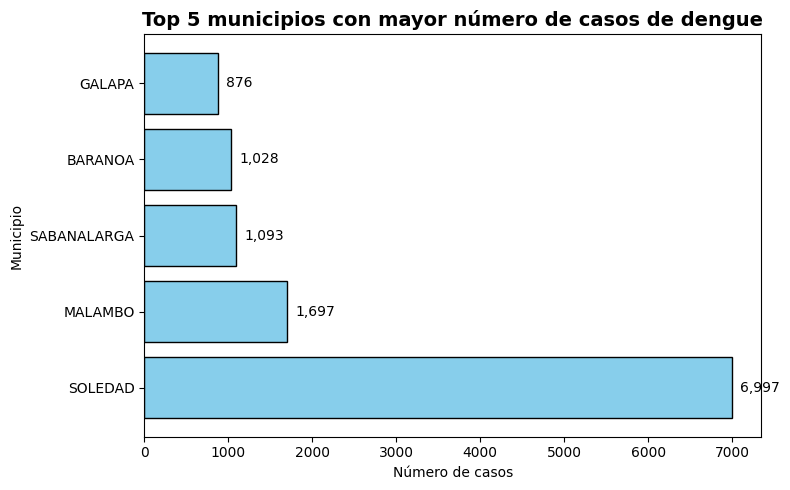

In [15]:
t = pd.DataFrame({
        "Conteo": df['municipio'].value_counts(dropna=False),
        "Proporción": df['municipio'].value_counts(normalize=True, dropna=False).round(4)
})

# Ordenar y seleccionar el top 5
top5 = t.sort_values("Conteo", ascending=False).head(5)

# Gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.barh(top5.index, top5["Conteo"], color="skyblue", edgecolor="black")

for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 100, bar.get_y() + bar.get_height()/2, 
             f"{xval:,}", va="center", fontsize=10)

plt.title("Top 5 municipios con mayor número de casos de dengue", fontsize=14, weight="bold")
plt.xlabel("Número de casos")
plt.ylabel("Municipio")
plt.tight_layout()
plt.show()

### 2.3 Variables temporales

In [16]:
describir_categorica(df["año"])


📌 Variable: año
      Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
año                                                               
2022    4257      0.2827     4054    203        0.9523      0.0477
2021    3172      0.2107     3100     72        0.9773      0.0227
2023    2144      0.1424     2115     29        0.9865      0.0135
2019    2063      0.1370     2031     32        0.9845      0.0155
2018    1614      0.1072     1592     22        0.9864      0.0136
2020    1295      0.0860     1273     22        0.9830      0.0170
2017     512      0.0340      501     11        0.9785      0.0215

-----------------------------------


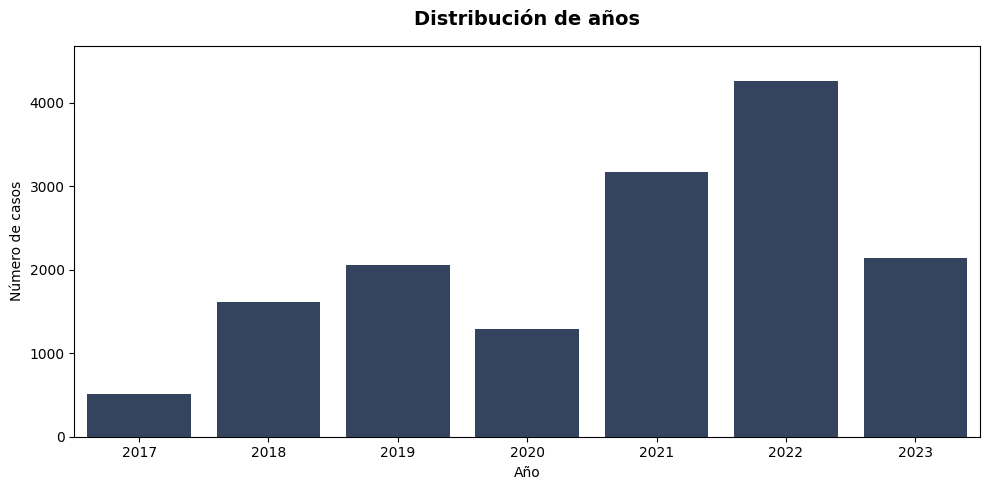

In [17]:
conteo_por_año = df['año'].value_counts(sort=False).sort_index()

    # Crear gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x=conteo_por_año.index.astype(str), y=conteo_por_año.values, color='#2E4265')

plt.title('Distribución de años', fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.xticks(rotation=0)
plt.ylim(0, max(conteo_por_año.values) * 1.1)
plt.tight_layout()
plt.show()


Durante el periodo 2017–2023, los casos de dengue presentaron variaciones importantes en su magnitud y gravedad. El año con mayor número de notificaciones fue 2022 (28,3%), en el que además se observó la proporción más elevada de casos graves (4,8%), lo que sugiere un comportamiento epidémico. Le siguieron en frecuencia los años 2021 (21,1%) y 2023 (14,2%), ambos con proporciones menores de gravedad (2,3% y 1,4% respectivamente).

En contraste, los años 2018–2020 aportaron entre 8% y 10% de los casos, con baja proporción de dengue grave (≤1,7%). El año con menor notificación fue 2017 (3,4%), manteniendo también baja gravedad (2,1%).

En conjunto, estos resultados muestran que la carga de la enfermedad no ha sido constante, con un pico marcado en 2022, seguido de una reducción en 2023. Esto refleja un patrón cíclico del dengue, en el que ciertos años concentran una mayor magnitud y severidad de los casos.

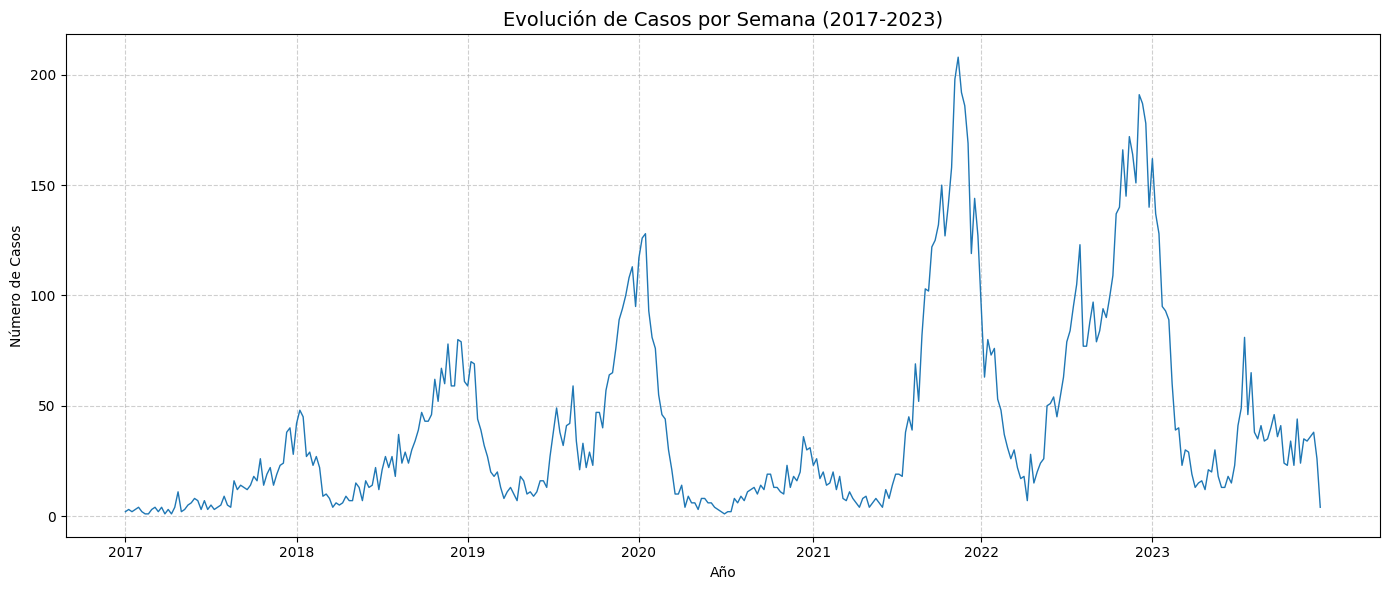

In [18]:
# Agrupar por año y semana
casos_semana = df.groupby(["año", "semana"]).size().reset_index(name="casos")

# Ordenar
casos_semana = casos_semana.sort_values(["año", "semana"]).reset_index(drop=True)

# Crear índice continuo
casos_semana["index"] = range(len(casos_semana))

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(casos_semana["index"], casos_semana["casos"], linewidth=1)

# Marcar solo los años en el eje X
años_unicos = casos_semana["año"].unique()
ticks = [casos_semana[casos_semana["año"] == año].index[0] for año in años_unicos]
plt.xticks(ticks, años_unicos, fontsize=10)

plt.title("Evolución de Casos por Semana (2017-2023)", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Número de Casos")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [19]:
week = tabla_descriptiva(df_edad, variable="semana", grupo="año")
week

,año,n,media,mediana,sd,q25,q75,minimo,maximo
0,2017,505,38.36,42.0,12.61,33.0,49.0,1,52
1,2018,1605,33.49,39.0,16.25,24.0,47.0,1,52
2,2019,2050,32.72,38.0,16.97,21.0,47.0,1,52
3,2020,1287,17.04,7.0,18.23,3.0,35.0,1,53
4,2021,3158,39.97,43.0,11.15,37.0,47.0,1,52
5,2022,4245,33.81,38.0,15.08,26.0,46.0,1,52
6,2023,2138,21.33,21.0,16.57,5.0,36.0,1,52


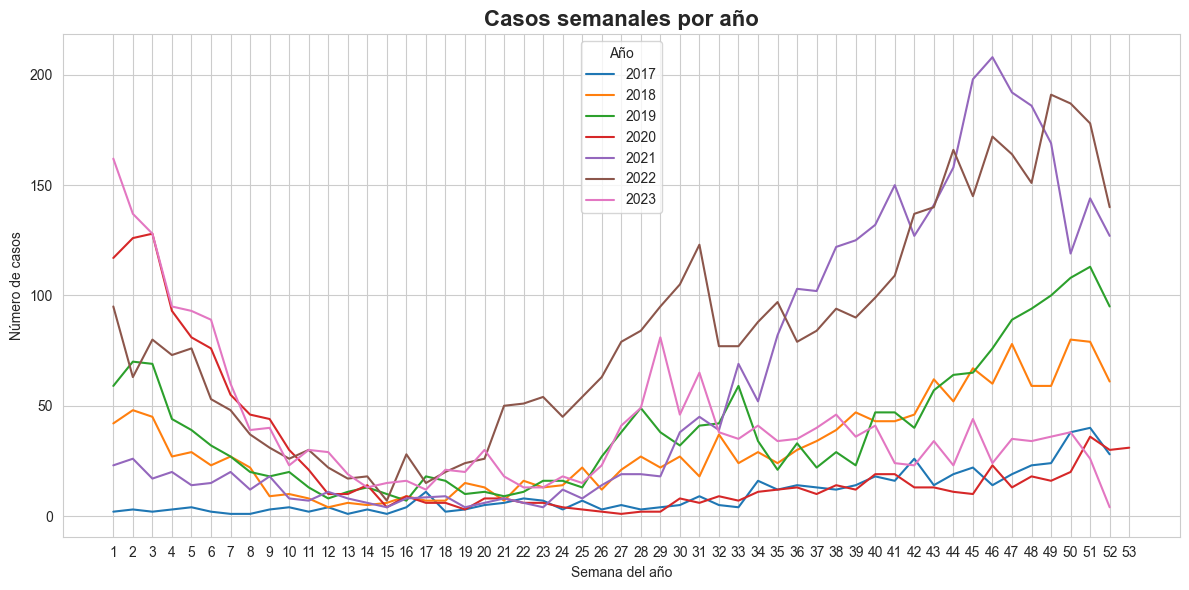

In [20]:
# Contar casos por semana y año
conteo_semanal = df.groupby(['año', 'semana']).size().reset_index(name='casos')

def graficar_casos_semanales_por_año(df_conteo, nombre_grafico="Casos semanales por año"):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Graficar cada año como una línea
    for año in sorted(df_conteo['año'].unique()):
        datos_año = df_conteo[df_conteo['año'] == año]
        plt.plot(datos_año['semana'], datos_año['casos'], label=str(año))

    plt.title(nombre_grafico, fontsize=16, fontweight='bold')
    plt.xlabel("Semana del año")
    plt.ylabel("Número de casos")
    plt.xticks(range(1, 54))  # Semanas ISO van de 1 a 53
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()

graficar_casos_semanales_por_año(conteo_semanal)

In [21]:
# Agrupar y pivotear
conteo_semanal_semanal = df.groupby(['año', 'semana']).size().reset_index(name='casos')
tabla_pivot = conteo_semanal.pivot(index='año', columns='semana', values='casos').fillna(0).astype(int)
tabla_pivot.loc['Total_semana'] = tabla_pivot.sum(axis=0)
# Mostrar la tabla
tabla_pivot

semana,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
año,,,,,,,,,,,,,,,,,,,,,
2017,2,3,2,3,4,2,1,1,3,4,...,19,22,14,19,23,24,38,40,28,0
2018,42,48,45,27,29,23,27,22,9,10,...,52,67,60,78,59,59,80,79,61,0
2019,59,70,69,44,39,32,27,20,18,20,...,64,65,76,89,94,100,108,113,95,0
2020,117,126,128,93,81,76,55,46,44,30,...,11,10,23,13,18,16,20,36,30,31
2021,23,26,17,20,14,15,20,12,18,8,...,158,198,208,192,186,169,119,144,127,0
2022,95,63,80,73,76,53,48,37,31,26,...,166,145,172,164,151,191,187,178,140,0
2023,162,137,128,95,93,89,60,39,40,23,...,23,44,24,35,34,36,38,26,4,0
Total_semana,500,473,469,355,336,290,238,177,163,121,...,493,551,577,590,565,595,590,616,485,31


In [22]:
tabla_pivot.to_csv("Conglomerado_casos.csv")

In [23]:
# Excluir la columna 'Total_año' si está presente
totales_por_semana = tabla_pivot.loc['Total_semana'].drop('Total_año', errors='ignore')

# Ordenar de mayor a menor
semanas_mayores = totales_por_semana.sort_values(ascending=False)

# Mostrar las semanas con más casos (por ejemplo, top 5)
print(semanas_mayores.head(5))

semana
51    616
49    595
50    590
47    590
46    577
Name: Total_semana, dtype: int64


In [24]:
# Excluir la columna 'Total_año' si está presente
totales_por_semana = tabla_pivot.loc['Total_semana'].drop('Total_año', errors='ignore')

# Ordenar de mayor a menor
semanas_min = totales_por_semana.sort_values(ascending=True)

# Mostrar las semanas con más casos (por ejemplo, top 5)
print(semanas_min.head(5))

semana
53    31
15    47
17    69
14    72
13    72
Name: Total_semana, dtype: int64


## 3. MAPAS

In [25]:
# REELEER DATA
#df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", encoding='latin_1', low_memory=False)
df.columns = df.columns.str.upper()

# Población proyectada
poblacion = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\tabla_municipios.csv", encoding='utf_8', low_memory=False)

# Shapefile de Atlántico
gdf = gpd.read_file(r"C:\Users\Hp\DENGUE\Data\dengue_data\atlantico_municipios.shp", encoding='utf_8')
gdf = gdf.rename(columns={'mpio_cnmbr': 'MUNICIPIO'})

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Hp\\DENGUE\\Data\\dengue_data\\tabla_municipios.csv'

In [139]:
# Agrupamos casos por municipio, año y evento
casos = df.groupby(["MUNICIPIO", "AÑO", "EVENTO"]).size().reset_index(name="casos")
# Total acumulado (sin año, solo municipio y evento)
casos_total = df.groupby(["MUNICIPIO", "EVENTO"]).size().reset_index(name="casos")

# Agrupar por municipio, año y evento
tabla_mun = df.groupby(["MUNICIPIO","AÑO","EVENTO"]).size().reset_index(name="casos")

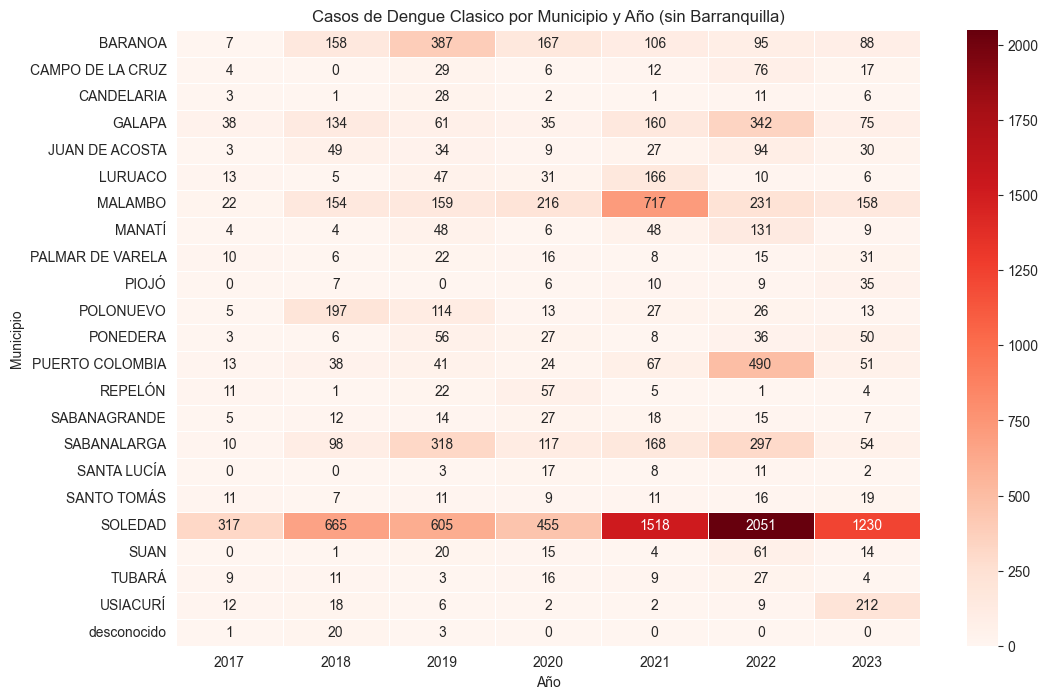

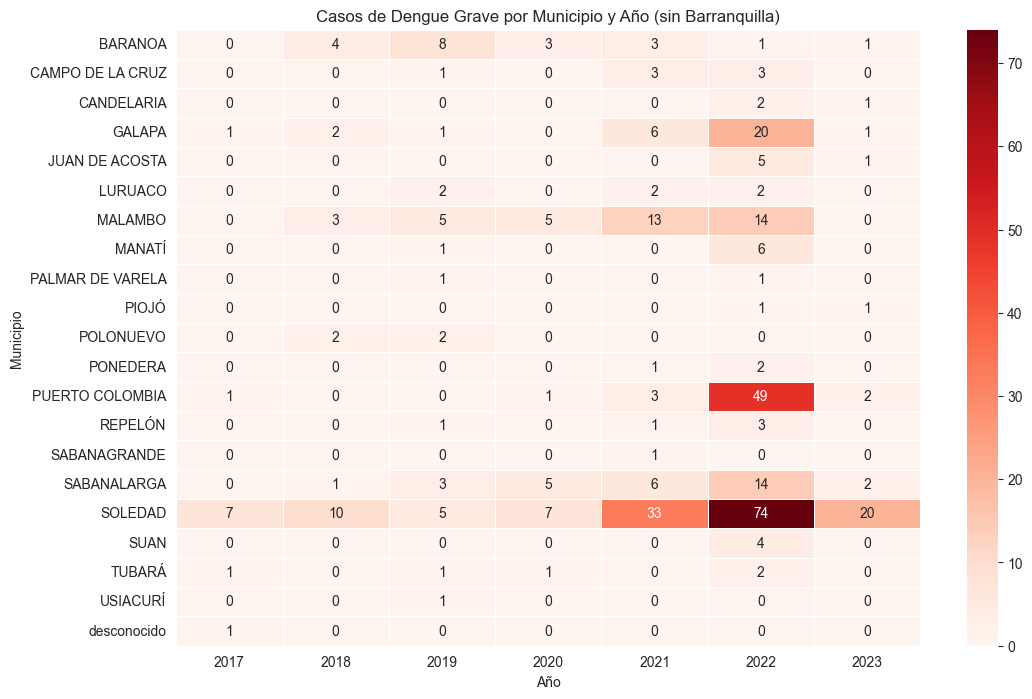

In [140]:
eventos = ["Clasico", "Grave"]

for evento in eventos:
    # Filtrar solo el evento actual
    tabla_evento = tabla_mun[tabla_mun["EVENTO"] == evento]

    # Crear tabla pivote para heatmap
    pivot = tabla_evento.pivot_table(
        index="MUNICIPIO", 
        columns="AÑO", 
        values="casos", 
        fill_value=0
    )

    # Validar si hay datos antes de graficar
    if pivot.empty or pivot.isna().all().all():
        print(f"⚠️ No hay datos para el evento '{evento}' después de filtrar. Se omite el gráfico.")
        continue

    pivot = pivot.fillna(0).astype(int)

    # Graficar heatmap
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt="d")
    plt.title(f"Casos de Dengue {evento} por Municipio y Año (sin Barranquilla)")
    plt.xlabel("Año")
    plt.ylabel("Municipio")
    plt.show()

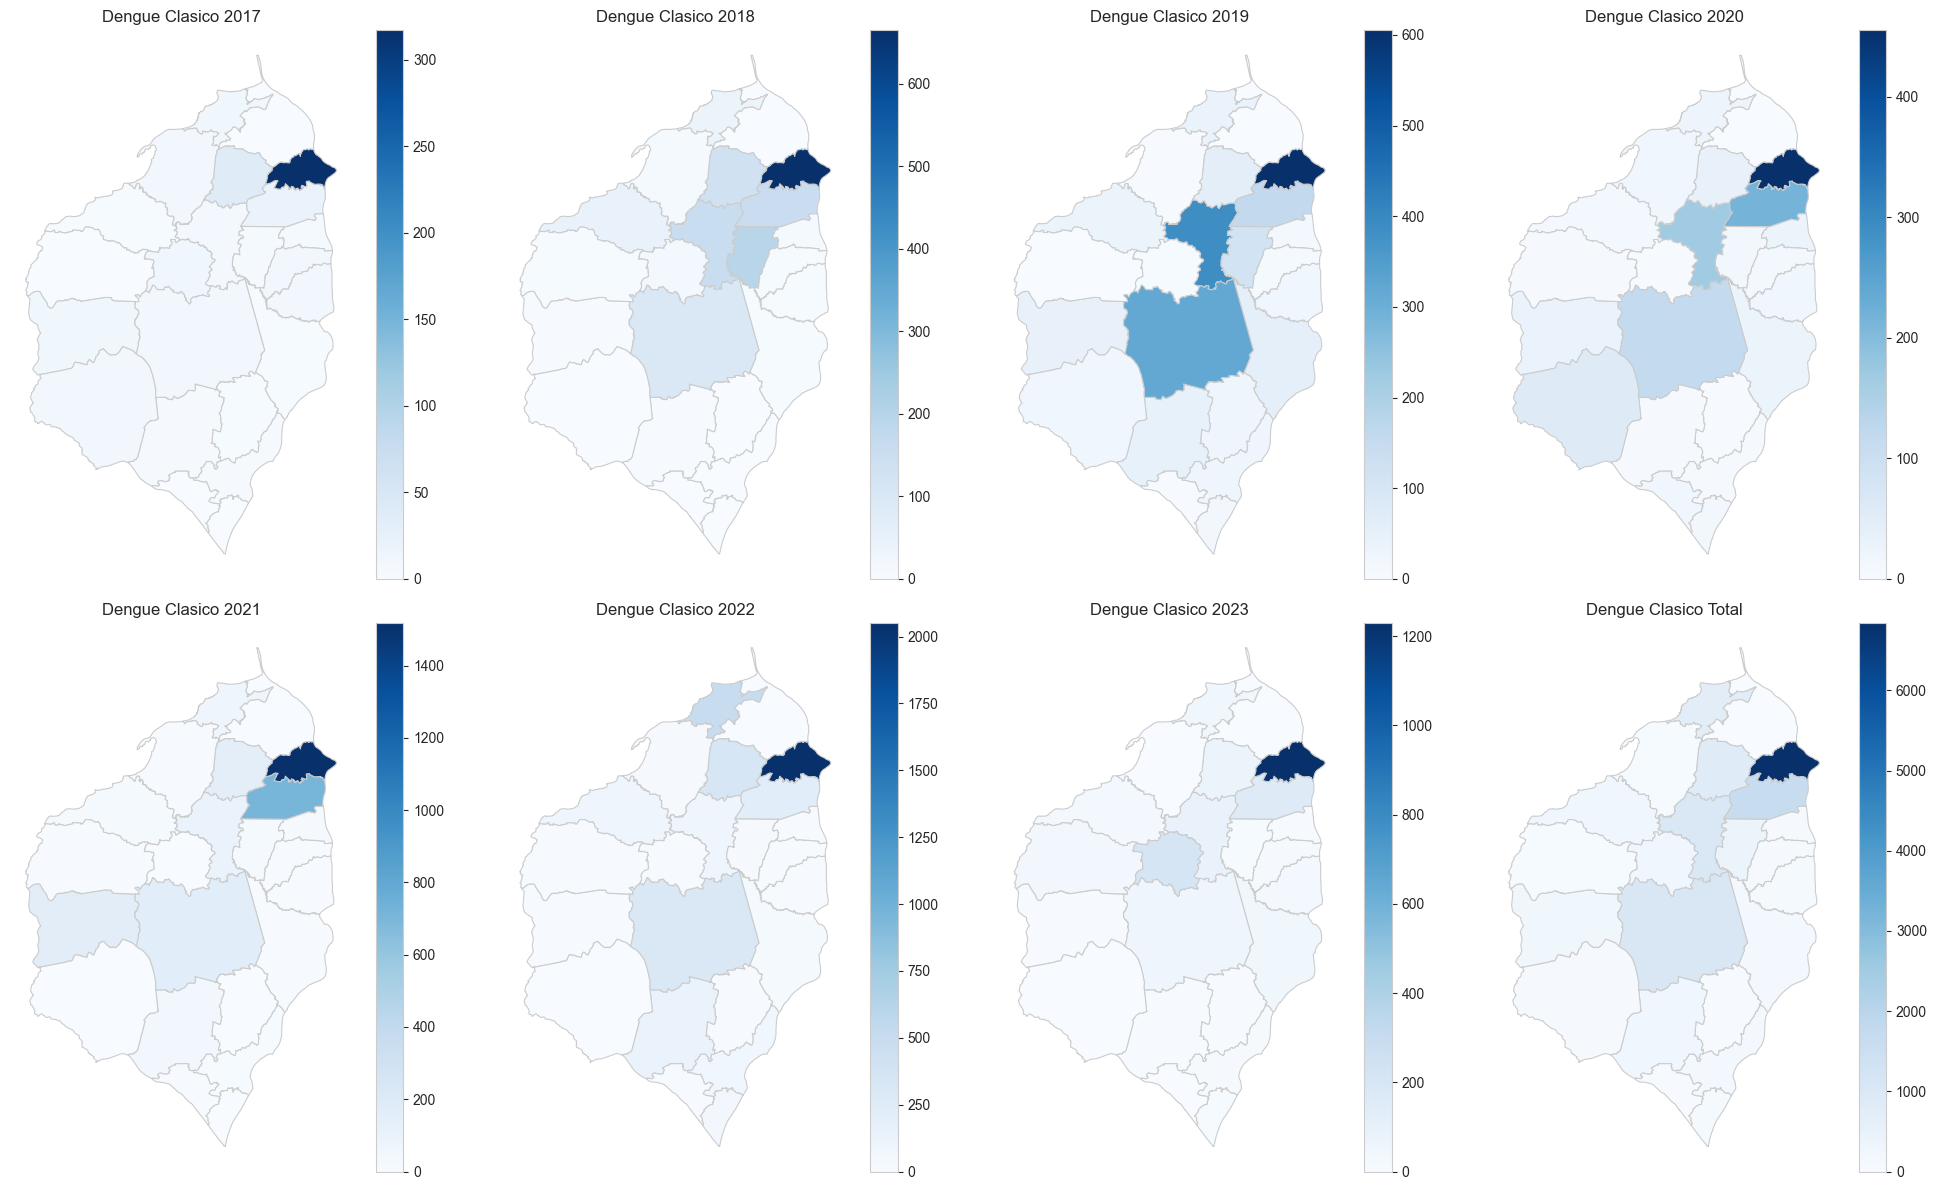

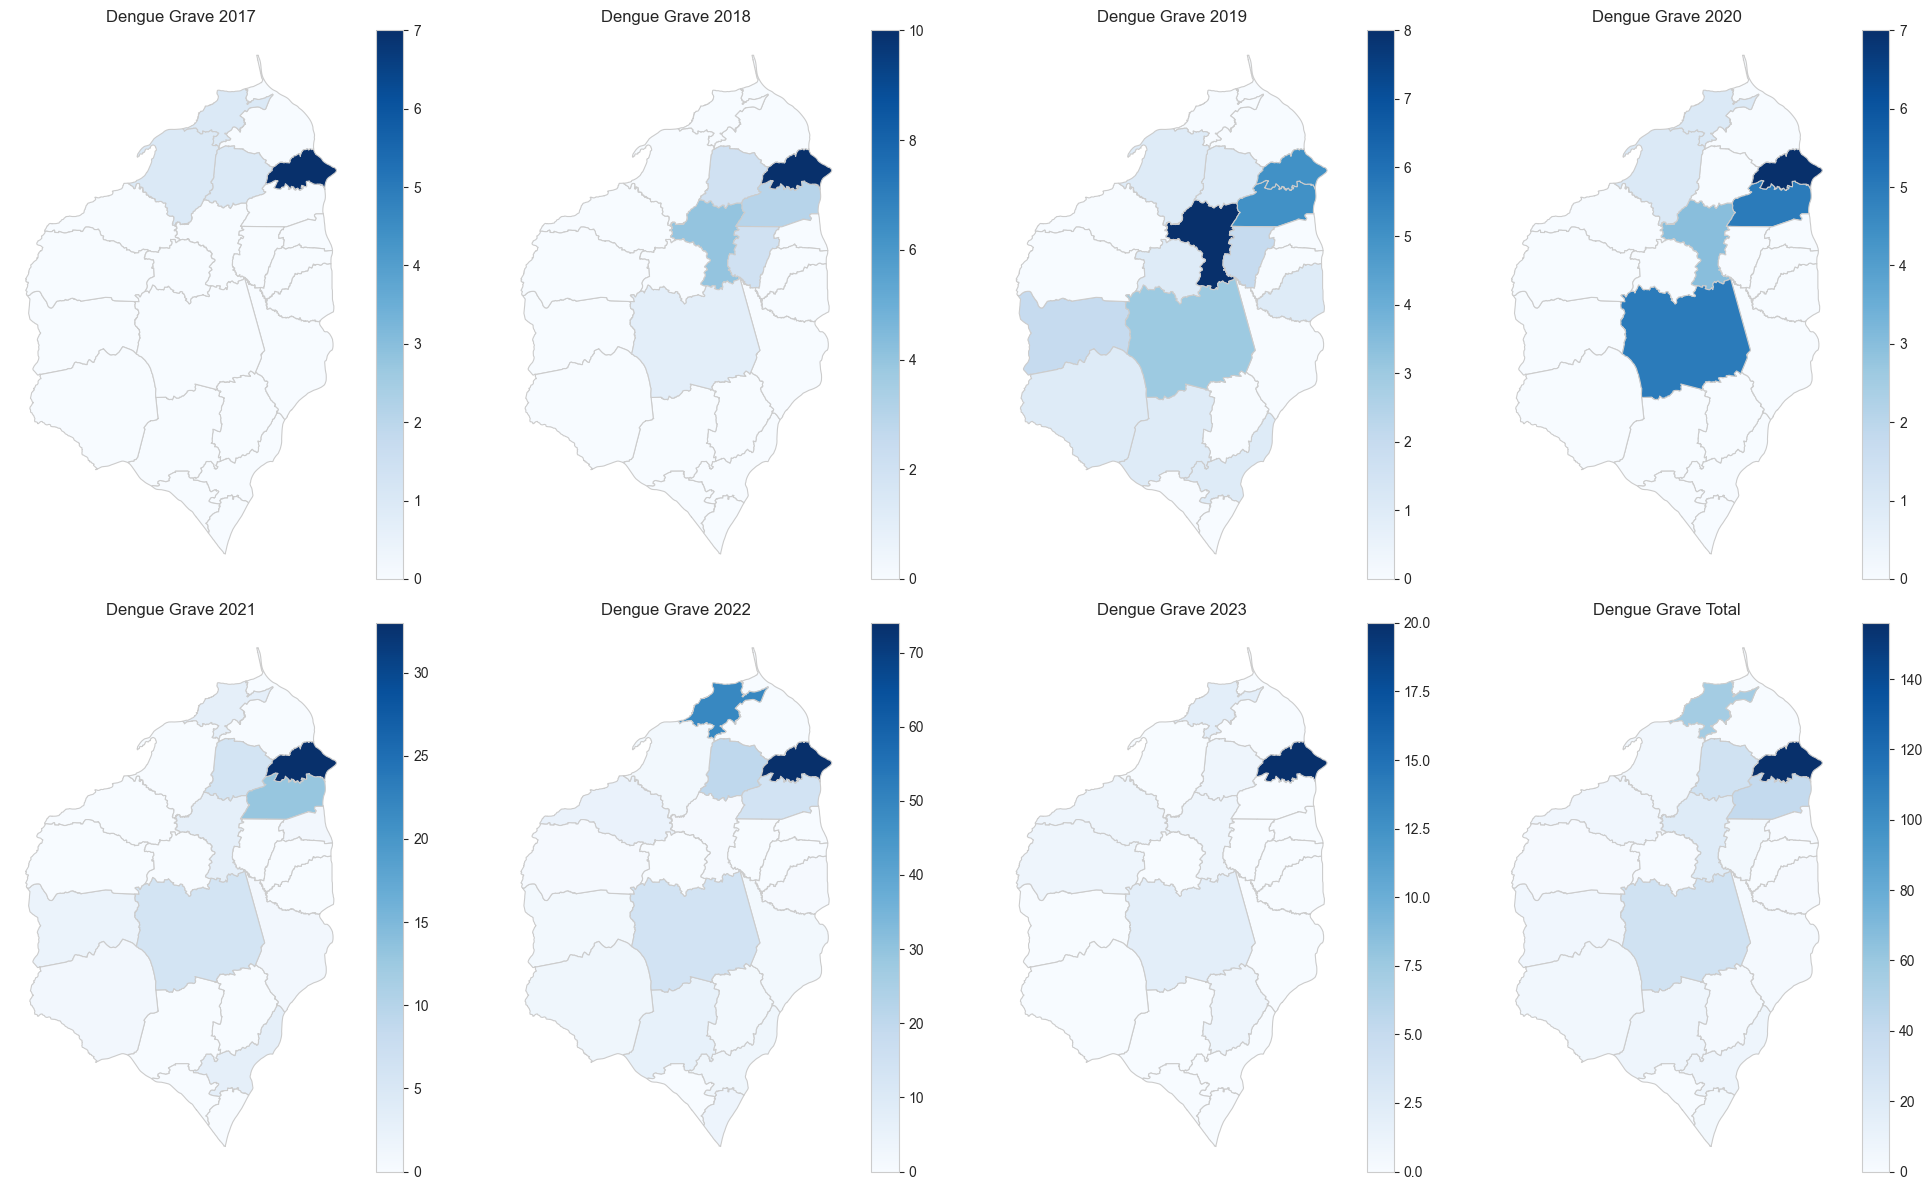

In [152]:
for evento in eventos:
    anios = sorted(df["AÑO"].unique())
    n = len(anios) + 1  # años + total
    filas = 2
    columnas = 4

    fig, axes = plt.subplots(filas, columnas, figsize=(5*columnas, 6*filas))
    axes = axes.flatten()  # Convierte la matriz de ejes en una lista

    for i, anio in enumerate(anios):
        casos_anio = df[(df["AÑO"] == anio) & (df["EVENTO"] == evento)]
        casos_anio = casos_anio.groupby("MUNICIPIO").size().reset_index(name="CASOS")
        gdf_plot = gdf.merge(casos_anio, on="MUNICIPIO", how="left").fillna(0)
        
        gdf_plot.plot(column="CASOS", cmap="Blues", linewidth=0.8, edgecolor="0.8",
                      legend=True, ax=axes[i])
        axes[i].set_title(f"Dengue {evento} {anio}")
        axes[i].axis("off")

    # Total de casos por evento
    casos_total = df[df["EVENTO"] == evento].groupby("MUNICIPIO").size().reset_index(name="CASOS")
    gdf_total = gdf.merge(casos_total, on="MUNICIPIO", how="left").fillna(0)

    gdf_total.plot(column="CASOS", cmap="Blues", linewidth=0.8, edgecolor="0.8",
                   legend=True, ax=axes[-1])
    axes[-1].set_title(f"Dengue {evento} Total")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


## Tasa de incidencia

4. Exploración bivariada (comparaciones)

4.1 Demografía vs evento/desenlace

Edad × hospitalización.

Sexo × tipo de caso.

Aseguradora × mortalidad.

4.2 Geografía vs desenlace

Municipios/localidades con mayor hospitalización o mortalidad.

Tasas de casos por 100.000 hab.

4.3 Temporalidad vs desenlace

Hospitalización y mortalidad por año y semana.

Comparaciones antes/después de picos epidémicos.

5. Pruebas estadísticas

Pruebas de proporción:

Diferencia en proporciones de hospitalización por sexo.

Diferencia en proporciones de mortalidad entre municipios/localidades.

Chi-cuadrado de independencia:

Sexo × tipo de caso.

Edad (categorías) × hospitalización.

Municipio × mortalidad.

Pruebas de medias:

Diferencia en promedio de edad entre hospitalizados vs no hospitalizados.

Diferencia en diferencia de días (síntomas→consulta) por municipio.

6. Análisis multivariado

Correlación entre variables numéricas

Edad, diferencia de días, semana.

Heatmap de correlaciones.

Análisis de correspondencias múltiples (ACM/MCA)

Para variables categóricas: sexo, etnia, aseguradora, municipio/localidad.

Ver si aparecen perfiles de pacientes.

Clustering exploratorio (opcional)

Agrupar barrios/localidades por perfil de casos.

7. Resumen y hallazgos clave

Principales patrones encontrados.

Variables críticas para explicar hospitalización y mortalidad.

Brechas de información (faltantes o inconsistencias).